<a href="https://colab.research.google.com/github/ikoghoemmanuell/Bizstech-Msc.-Cybersecurity-/blob/main/Copy_of_model_2_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

Find below a simple example, with just 10 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

# Installation

In [1]:
# !pip install zipfile

!pip install transformers
!pip install datasets
!pip install --upgrade accelerate
!pip install sentencepiece

## Importing Libraries

In [2]:
import huggingface_hub # Importing the huggingface_hub library for model sharing and versioning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import os

from datasets import DatasetDict, Dataset
from sklearn.metrics import mean_squared_error, classification_report

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from google.colab import drive
# import zipfile
import torch

## Load Dataset and Delete Null Values

In [3]:
real_url = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv"
fake_url = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv"
fake_url1 = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_fake.csv"
real_url1 = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_real.csv"

# Read the csv file from the url
fake1 = pd.read_csv(fake_url1)
real1 = pd.read_csv(real_url1)
fake = pd.read_csv(fake_url)
real = pd.read_csv(real_url)

# A way to delete rows with empty or null values
fake1 = fake1[~fake1.isna().any(axis=1)]
real1 = real1[~real1.isna().any(axis=1)]
fake = fake[~fake.isna().any(axis=1)]
real = real[~real.isna().any(axis=1)]

In [4]:
fake["label"] = 1
real["label"] = 0
fake1["label"] = 1
real1["label"] = 0

<ipython-input-4-656069b16a4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real["label"] = 0


In [6]:
df2 = pd.concat([fake, real], axis =0 )
df1 = pd.concat([fake1, real1], axis =0 )
df = pd.concat([df2, df1], axis =0 )
df.head(10)

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,1
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,1
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,1
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,1
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,1
5,gossipcop-5189580095,www.townandcountrymag.com/society/tradition/a1...,Here's What Really Happened When JFK Jr. Met P...,890253005299351552\t890401381814870016\t890491...,1
6,gossipcop-9588339534,www.foxnews.com/entertainment/2016/12/16/bigge...,Biggest celebrity scandals of 2016,683226380742557696\t748604615503929345\t748604...,1
7,gossipcop-8753274298,www.eonline.com/news/958257/caitlyn-jenner-add...,Caitlyn Jenner Addresses Rumored Romance With ...,1026891446081728512\t1026891745219543043\t1026...,1
8,gossipcop-8105333868,www.inquisitr.com/3871816/taylor-swift-reporte...,Taylor Swift Reportedly Reacts To Tom Hiddlest...,818928533569437697\t819100640878202880\t819174...,1
9,gossipcop-2803748870,www.huffingtonpost.com/entry/kate-mckinnon-the...,"For The Love Of God, Why Can't Anyone Write Ka...",816030248190046212\t816030859484626947\t816049...,1


## Splitting the dataset

In [7]:
# Split the train data => {train, eval}  train 80%, test 20%
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [8]:
# get the first 5 rows of the train set to make sure it looks right
train.head()

,id,news_url,title,tweet_ids,label
76,gossipcop-2076682877,celebrityinsider.org/blake-shelton-gwen-stefan...,Blake Shelton & Gwen Stefani Hoping Exes Miran...,898706288749682688\t898709998930448384\t898710...,1
14224,gossipcop-846669,http://www.biphoo.com/celebrity/melania-trump/...,Melania Trump Switches Up Her Style In A Milit...,857726321719300096\t857726321018851328\t857726...,0
5633,gossipcop-900998,https://people.com/style/best-beauty-product-l...,The Best Beauty Launches of 2017,943121496981024768\t943121584771887104\t943121...,0
14958,gossipcop-886107,http://www.trueara.com/jessie-james-decker-get...,Jessie James Decker Gets Hot and Bothered Watc...,917853564634124290\t917853773330108416\t917856...,0
8765,gossipcop-841974,https://en.wikipedia.org/wiki/Harry_Hamlin,Harry Hamlin,850366149242105856\t850366154258485248\t850366...,0


In [9]:
# check datatypes of the train set, object can mean text or string
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17125 entries, 76 to 1114
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         17125 non-null  object
 1   news_url   17125 non-null  object
 2   title      17125 non-null  object
 3   tweet_ids  17125 non-null  object
 4   label      17125 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 802.7+ KB


In [10]:
# get the first 5 rows of the eval or test set
eval.head()

,id,news_url,title,tweet_ids,label
11546,gossipcop-876023,http://time.com/4842464/beyonce-jay-z-baby-names/,Beyonce and Jay-Z Name Their Twin Babies,901221405425106945,0
1689,gossipcop-8695513210,www.imdb.com/news/ni61600964,"HollywoodLife, MediaTakeOut Spread False Claim...",917838613521498112\t917841678425296896\t917853...,1
7350,gossipcop-930229,https://www.brides.com/story/prince-william-wo...,"Prince William Says He Is Still ""Working On"" a...",989578993853698048\t989579235089006593\t989581...,0
7370,gossipcop-910229,https://www.msn.com/en-us/music/story/seen-the...,"Seen these ""Real World"" contestants lately?",959065415598133248\t959065823230005248\t959066...,0
7497,gossipcop-874619,https://www.who.com.au/emily-vancamp-josh-bowm...,Emily VanCamp and Josh Bowman adopt a rescue dog,899045988735778816\t899046095980036099\t899046...,0


In [11]:
eval.label.unique()

array([0, 1])

In [12]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (17125, 5), eval is (4282, 5)


([<matplotlib.patches.Wedge at 0x7f0100562a40>,
 [Text(-0.8404268844151825, 0.8565527724268889, 'Fake'),
  Text(0.8404268443170523, -0.8565528117701099, 'True')],
 [Text(-0.49024901590885644, 0.4996557839156851, '24.7%'),
  Text(0.49024899251828047, -0.49965580686589744, '75.3%')])

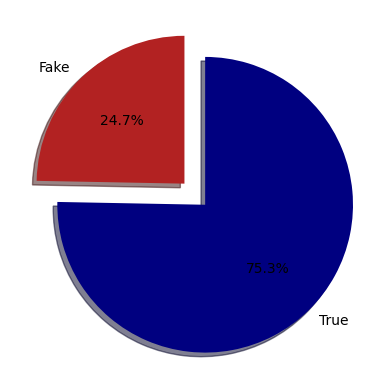

In [13]:
# 90 true, 10 fake, 70, 30
# 40, 60 good, 55, 45 is good
# Checking if our df is well balanced
label_size = [df['label'].sum(),len(df['label'])-df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Creating a pytorch dataset

In [14]:
# transformers library allows you to use pytorch or tensorflow to save your dataset
# pytorch dataset looks like a dictoinary
# using this rep works well with the transformers library

# Create a pytorch dataset to ensure consistency in our data handling

# Create a train and eval datasets using the specified columns from the DataFrame
train_dataset = Dataset.from_pandas(train[['id', 'title', 'label']])
eval_dataset = Dataset.from_pandas(eval[['id', 'title', 'label']])

# Combine the train and eval datasets into a DatasetDict
dataset = DatasetDict({'train': train_dataset, 'eval': eval_dataset})

# Remove the '__index_level_0__' column from the dataset
dataset = dataset.remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'label'],
        num_rows: 17125
    })
    eval: Dataset({
        features: ['id', 'title', 'label'],
        num_rows: 4282
    })
})

## Preprocessing and tokenization

In [15]:
# define helper functions

# funtion to replace usernames and links with placeholders.
def preprocess(text):
  # "@user my name is john"
  # "http my name is john"
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# no need for encoding: Fake=1, True=0 bcuz the target variable called label is already encoded

In [16]:
# Define the apply_preprocess function
def apply_preprocess(dataset, column='title'):
    return dataset.map(lambda example: {column: preprocess(example[column])},
                       remove_columns=[column])

# Apply the preprocess function to the 'title' column in both 'train' and 'eval' datasets
dataset['train'] = apply_preprocess(dataset['train'])
dataset['eval'] = apply_preprocess(dataset['eval'])

Map:   0%|          | 0/17125 [00:00<?, ? examples/s]

Map:   0%|          | 0/4282 [00:00<?, ? examples/s]

###Tokenization

Text(0, 0.5, 'Number of texts')

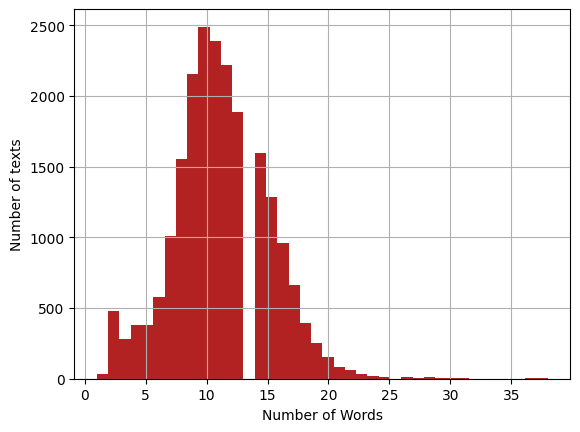

In [17]:
# Plot histogram of the number of words in train data 'text'
seq_len = [len(text.split()) for text in df['title']]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [18]:
# define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("jy46604790/Fake-News-Bert-Detect")

def tokenize_data(example):
    return tokenizer(example['title'], padding='max_length', # compress all sentences to maximum of 30 words which is the max_length
                     truncation=True, # cut the sentenced to 30_words
                     max_length=40 # increasing the max length doesn't guarantee a better score
                     )

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns or columns that are not tokenized
remove_columns = ['id', 'title']
dataset = dataset.map(remove_columns=remove_columns)
dataset

Map:   0%|          | 0/17125 [00:00<?, ? examples/s]

Map:   0%|          | 0/4282 [00:00<?, ? examples/s]

Map:   0%|          | 0/17125 [00:00<?, ? examples/s]

Map:   0%|          | 0/4282 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 17125
    })
    eval: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4282
    })
})

## Trianing

In [19]:
# Loading a pretrain model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("jy46604790/Fake-News-Bert-Detect")

In [20]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("test_trainer",
                                  num_train_epochs=2, # epoch is ow many times you repeat training
                                  load_best_model_at_end=True,
                                  save_strategy='epoch',
                                  evaluation_strategy='epoch',
                                  logging_strategy='epoch',
                                  per_device_train_batch_size=32, # smaller batches take longer to train
                                  )

In [21]:
# set up the optimizer with the PyTorch implementation of AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # I specified the optimizer to avoid a warning message

In [22]:
train_dataset = dataset['train'].shuffle(seed=24)
eval_dataset = dataset['eval'].shuffle(seed=24) # scatter the dataset 24 times randomly

In [23]:
def compute_metrics(eval_pred):      # specify the evaluation metric
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "rmse": mean_squared_error(labels, predictions, squared=False),
        "classification_report": classification_report(labels, predictions)
    }

In [24]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()  # rmse 0 to 1 closer to 0 means better performance.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rmse,Classification Report
1,0.416200,0.332793,0.370251,precision recall f1-score support 0 0.90 0.92 0.91 3224 1 0.75 0.68 0.71 1058 accuracy 0.86 4282 macro avg 0.82 0.80 0.81 4282 weighted avg 0.86 0.86 0.86 4282
2,0.287200,0.319532,0.357413,precision recall f1-score support 0 0.90 0.94 0.92 3224 1 0.78 0.67 0.72 1058 accuracy 0.87 4282 macro avg 0.84 0.80 0.82 4282 weighted avg 0.87 0.87 0.87 4282


Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3224
           1       0.75      0.68      0.71      1058

    accuracy                           0.86      4282
   macro avg       0.82      0.80      0.81      4282
weighted avg       0.86      0.86      0.86      4282
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3224
           1       0.78      0.67      0.72      1058

    accuracy                           0.87      4282
   macro avg       0.84      0.80      0.82      4282
weighted avg       0.87      0.87      0.87      4282
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Ten

TrainOutput(global_step=1072, training_loss=0.3516685571243514, metrics={'train_runtime': 289.1357, 'train_samples_per_second': 118.457, 'train_steps_per_second': 3.708, 'total_flos': 704027628600000.0, 'train_loss': 0.3516685571243514, 'epoch': 2.0})

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [26]:
# Launch the final evaluation
trainer.evaluate()  # eval loss is the performance cost of finetuning (0 to 1) 0.5 and above is not suitable.

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3224
           1       0.78      0.67      0.72      1058

    accuracy                           0.87      4282
   macro avg       0.84      0.80      0.82      4282
weighted avg       0.87      0.87      0.87      4282
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.31953179836273193,
 'eval_rmse': 0.357412989185984,
 'eval_classification_report': '              precision    recall  f1-score   support\n\n           0       0.90      0.94      0.92      3224\n           1       0.78      0.67      0.72      1058\n\n    accuracy                           0.87      4282\n   macro avg       0.84      0.80      0.82      4282\nweighted avg       0.87      0.87      0.87      4282\n',
 'eval_runtime': 11.7215,
 'eval_samples_per_second': 365.311,
 'eval_steps_per_second': 45.728,
 'epoch': 2.0}

## Pushing to HuggingFace
Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

In [27]:
huggingface_hub.notebook_login()
# login to the Hugging Face Hub with your token

In [28]:
# # Push model and tokenizer to HugginFace
model.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert") # (username/model_name)
tokenizer.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:803 in push_to_hub             │
│                                                                                                  │
│    800 │   │   else:                                                                             │
│    801 │   │   │   working_dir = repo_id.split("/")[-1]                                          │
│    802 │   │                                                                                     │
│ ❱  803 │   │   repo_id = self._create_repo(                                                      │
│    804 │   │   │   repo_id, private=private, use_auth_token=use_auth_token, repo_url=repo_url,   │
│    805 │   │   )                                                                                 │
│    806                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:661 in _create_repo            │
│                                                                                                  │
│    658 │   │   │   │   │   repo_id = repo_id.split("/")[-1]                                      │
│    659 │   │   │   │   repo_id = f"{organization}/{repo_id}"                                     │
│    660 │   │                                                                                     │
│ ❱  661 │   │   url = create_repo(repo_id=repo_id, token=use_auth_token, private=private, exist_  │
│    662 │   │                                                                                     │
│    663 │   │   # If the namespace is not there, add it or `upload_file` will complain            │
│    664 │   │   if "/" not in repo_id and url != f"{HUGGINGFACE_CO_RESOLVE_ENDPOINT}/{repo_id}":  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:118 in _inner_fn    │
│                                                                                                  │
│   115 │   │   if check_use_auth_token:                                                           │
│   116 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   117 │   │                                                                                      │
│ ❱ 118 │   │   return fn(*args, **kwargs)                                                         │
│   119 │                                                                                          │
│   120 │   return _inner_fn  # type: ignore                                                       │
│   121                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:2304 in create_repo            │
│                                                                                                  │
│   2301 │   │   │   # Testing purposes only.                                                      │
│   2302 │   │   │   # See https://github.com/huggingface/huggingface_hub/pull/733/files#r8206044  │
│   2303 │   │   │   json["lfsmultipartthresh"] = self._lfsmultipartthresh  # type: ignore         │
│ ❱ 2304 │   │   headers = self._build_hf_headers(token=token, is_write_action=True)               │
│   2305 │   │   r = get_session().post(path, headers=headers